In [1]:
from scipy.integrate import quad, trapz, fixed_quad
import theano
import theano.tensor as T
from theano.tests.unittest_tools import verify_grad
from theano.compile.ops import as_op

import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt

import astropy.units as u

from tqdm import tqdm

from gammapy.spectrum import CountsPredictor, CountsSpectrum

from utils import load_spectrum_observations, plot_spectra, Log10Parabola, integrate_spectrum, wstat_profile
from forward_fold_model import model_probability, ln_profile_likelihood

%matplotlib inline

In [2]:
# theano.config.floatX ='float32'
# print(theano.config)
class Integrate(theano.Op):
    def __init__(self, expr, var, lower, upper, *inputs):
        super().__init__()
        self._expr = expr
        self._var = var
        self._extra_vars = inputs
        self.lower = lower
        self.upper = upper
        self._func = theano.function(
            [var] + list(self._extra_vars),
            self._expr,
            on_unused_input='ignore'
        )
    
    def make_node(self, *inputs):
        assert len(self._extra_vars)  == len(inputs)
        return theano.Apply(self, list(inputs), [T.dscalar().type()])
    
    def perform(self, node, inputs, out):
        x = np.linspace(self.lower, self.upper, num=3)
        y = np.array([self._func(i , *inputs) for i in x])
        val = trapz(y, x)
#         print(val)
#         val = quad(self._func, self.lower, self.upper, args=tuple(inputs))[0]
        out[0][0] = np.array(val)
        
    def grad(self, inputs, grads):
        out, = grads
        grads = T.grad(self._expr, self._extra_vars)
        dargs = []
        for grad in grads:
            integrate = Integrate(grad, self._var, self.lower, self.upper, *self._extra_vars)
            darg = out * integrate(*inputs)
            dargs.append(darg)
            
        return dargs

In [3]:
def apply_range(*arr, fit_range, bins):
    idx = np.searchsorted(bins.to(u.TeV).value, fit_range.to(u.TeV).value )
    return [a[idx[0]:idx[1]] for a in arr]

def forward_fold_gammapy(amplitude, alpha, beta, observation):
#     bins = obs.on_vector.energy.bins
    model = Log10Parabola(
        amplitude=amplitude * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
        reference=1 * u.Unit('TeV'),
        alpha=alpha * u.Unit(''),
        beta=beta * u.Unit(''),
    )
    
    predictor = CountsPredictor(model=model, aeff=observation.aeff, edisp=observation.edisp, livetime=observation.livetime)
    predictor.run()
    counts = predictor.npred.data.data
#     counts *= observation.on_vector.areascal
    return counts.value

In [124]:
def forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation, fit_range=None):

    obs_bins = observation.on_vector.energy.bins.to_value(u.TeV)

    
    aeff_bins = observation.aeff.energy
    e_reco_bins = observation.edisp.e_reco
    e_true_bins = observation.edisp.e_true
     
#     lo = obs_bins.min()
#     hi = obs_bins.max()
#     print(hi, lo)
#     if fit_range:
#         lo = max(fit_range[0].to_value(u.TeV), lo)
#         hi = min(fit_range[1].to_value(u.TeV), hi )
#     print(hi, lo)
#     e_mask = (obs_bins >= lo ) & (obs_bins <= hi)
#     print(e_mask, obs_bins)
#     aeff_mask = (aeff_bins.lo.to_value(u.TeV) > lo ) & (aeff_bins.hi.to_value(u.TeV) <= hi)
#     e_reco_mask = (e_reco_bins.lo.to_value(u.TeV) > lo ) & (e_reco_bins.hi.to_value(u.TeV) <= hi)
#     e_true_mask = (e_true_bins.lo.to_value(u.TeV) > lo ) & (e_true_bins.hi.to_value(u.TeV) <= hi)
    
   
    lower =  e_true_bins.lo.to_value(u.TeV)
    upper = e_true_bins.hi.to_value(u.TeV)

    amplitude *= 1e-11
    
    energy = T.dscalar('energy')
    amplitude_ = T.dscalar('amplitude_')
    alpha_ = T.dscalar('alpha_')
    beta_ = T.dscalar('beta_')

    func = amplitude_ * energy **(-alpha_ - beta_ * T.log10(energy))
    
    counts = []
    for a, b in zip(lower, upper):
        c = Integrate(func, energy, a, b, amplitude_, alpha_, beta_)(amplitude, alpha, beta)
        counts.append(c)

    counts = T.stack(counts)
    aeff = observation.aeff.data.data.to_value(u.cm**2).astype(np.float32)
    aeff = T.constant(aeff)
    

    counts *= aeff
    counts *= theano.shared(observation.livetime.to_value(u.s))
    edisp = observation.edisp.pdf_matrix
    edisp = T.constant(edisp)
    
    if fit_range:
        idx = np.searchsorted(obs_bins, fit_range.to_value(u.TeV))
        return T.dot(counts, edisp)[idx[0]:idx[1]]

    return T.dot(counts, edisp)

In [125]:
obs_list, fit_range = load_spectrum_observations('fact')
observation = obs_list[0]
energy_bins = observation.on_vector.energy.bins

In [126]:
def wstat_model(amplitude, alpha, beta, observation, fit_range):
    mu_sig = forward_fold_gammapy(amplitude, alpha, beta, observation=observation)
#     print(mu_sig.shape)
    on_data = observation.on_vector.data.data.value
    off_data = observation.off_vector.data.data.value
    
    mu_sig, on_data, off_data, obs_alpha = apply_range(mu_sig, on_data, off_data, observation.alpha, fit_range=fit_range, bins=energy_bins)
    p = ln_profile_likelihood(mu_sig, on_data, off_data, alpha=obs_alpha)
    p = -0.5*sum(p)
#     print('Prob:', p)
#     print('n_on:', on_data)
#     print('n_off:', off_data)
#     print('obs_alpha:', obs_alpha)
    return p, mu_sig

wstat_model(4, 2, 0.5, observation, fit_range=fit_range)

(6011.934915181168,
 array([ 2.83641875,  5.03451983,  8.58513145, 13.73386645, 20.43515058,
        27.81452573, 34.29191945, 39.77983177, 43.17620902, 43.75214362,
        43.23565957, 40.99682698, 36.98690407, 33.15867575, 29.14912131,
        24.9871197 , 21.71731737, 18.67498731, 15.63194352, 13.21337521,
        11.05064186,  9.0374708 ,  7.52087301,  6.18769006,  4.93665392,
         3.97537069,  3.13799023,  2.4017132 ,  1.86052837,  1.42260807,
         1.05535167,  0.78090854,  0.54856758,  0.35638484]))

In [127]:
def wstat_model_symbolic(mu_sig, observation, fit_range):
    on_data = observation.on_vector.data.data.value
    off_data = observation.off_vector.data.data.value
    
    mu_sig, on_data, off_data, obs_alpha = apply_range(mu_sig, on_data, off_data, observation.alpha, fit_range=fit_range, bins=energy_bins)
    p = ln_profile_likelihood(mu_sig, on_data, off_data, alpha=obs_alpha)
    p = -0.5*sum(p)
    return p, mu_sig

In [128]:
cf_range = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation, fit_range=fit_range)
cf = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation,)
cf_range.eval({amplitude: 4.0, alpha: 2.0, beta: 0.5}), cf.eval({amplitude: 4.0, alpha: 2.0, beta: 0.5})


(array([ 2.84025332,  5.04124389,  8.59653947, 13.75222054, 20.46277659,
        27.85280276, 34.34030109, 39.83747791, 43.24062197, 43.81950991,
        43.30430585, 41.06400937, 37.04957655, 33.21675532, 29.2019266 ,
        25.03393839, 21.75930759, 18.71221531, 15.6640727 , 13.24134702,
        11.07473968,  9.05777379,  7.53825687,  6.20240107,  4.94872232,
         3.98535148,  3.14608744,  2.40808983,  1.86560984,  1.42660315,
         1.05839455,  0.78321661,  0.55023111,  0.35749661]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.90166695e-12, 1.20963788e-10, 1.97858144e-09, 2.89976672e-08,
        3.90112301e-07, 3.15808046e-06, 1.79858867e-05, 8.84920744e-05,
        3.70745719e-04, 1.20682666e-03, 3.44870699e-03, 8.79808089e-03,
        1.80896745e-02, 3.59774248e-02, 6.44591121e-02, 1.09898665e-01,
        1.84462442e-01, 3.07398537e-01, 5.18161056e-01, 8.97690117e-

In [129]:
amplitude = T.dscalar('amplitude')
alpha = T.dscalar('alpha')
beta = T.dscalar('beta')
cf = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation, fit_range=fit_range)
counts_symbolic = cf.eval({amplitude: 4.0, alpha: 2.0, beta: 0.5})

_, counts_gammapy = wstat_model(4, 2, 0.5, observation, fit_range=fit_range)

_, counts_emcee = model_probability([4, 2, 0.5], [observation], fit_range=fit_range)


print(counts_symbolic.shape, counts_gammapy.shape, counts_emcee.shape)
counts_symbolic, counts_gammapy, counts_emcee

(34,) (34,) (34,)


(array([ 2.84025332,  5.04124389,  8.59653947, 13.75222054, 20.46277659,
        27.85280276, 34.34030109, 39.83747791, 43.24062197, 43.81950991,
        43.30430585, 41.06400937, 37.04957655, 33.21675532, 29.2019266 ,
        25.03393839, 21.75930759, 18.71221531, 15.6640727 , 13.24134702,
        11.07473968,  9.05777379,  7.53825687,  6.20240107,  4.94872232,
         3.98535148,  3.14608744,  2.40808983,  1.86560984,  1.42660315,
         1.05839455,  0.78321661,  0.55023111,  0.35749661]),
 array([ 2.83641875,  5.03451983,  8.58513145, 13.73386645, 20.43515058,
        27.81452573, 34.29191945, 39.77983177, 43.17620902, 43.75214362,
        43.23565957, 40.99682698, 36.98690407, 33.15867575, 29.14912131,
        24.9871197 , 21.71731737, 18.67498731, 15.63194352, 13.21337521,
        11.05064186,  9.0374708 ,  7.52087301,  6.18769006,  4.93665392,
         3.97537069,  3.13799023,  2.4017132 ,  1.86052837,  1.42260807,
         1.05535167,  0.78090854,  0.54856758,  0.35638484]),


In [130]:
amplitude = T.dscalar('amplitude')
alpha = T.dscalar('alpha')
beta = T.dscalar('beta')
cf = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation)
mu_sig = cf.eval({amplitude: 4.0, alpha: 2.0, beta: 0.5})

p_symbolic, counts_symbolic = wstat_model_from_counts(mu_sig, observation, fit_range=fit_range)
p_gammapy, counts_gammapy = wstat_model(4, 2, 0.5, observation, fit_range=fit_range)

p_emcee, counts_emcee = model_probability([4, 2, 0.5], [observation], fit_range=fit_range)

p_symbolic, p_gammapy, p_emcee

(6011.801365062534, 6011.934915181168, 6011.934915181169)

625it [00:01, 350.55it/s]


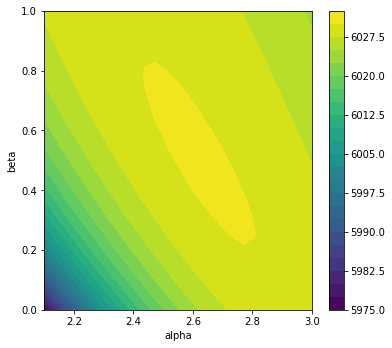

In [131]:

N = 25
betas = np.linspace(0, 1, N)
alphas = np.linspace(2.1, 3.0, N)
a, b = np.meshgrid(alphas, betas)

zs = []
for alpha, beta in tqdm(zip(a.ravel(), b.ravel())):
    p, _ = model_probability([4, alpha, beta], [observation], fit_range=fit_range)
    zs.append(p)

zs = np.array(zs)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5.5))
cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=24)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

625it [00:01, 438.39it/s]


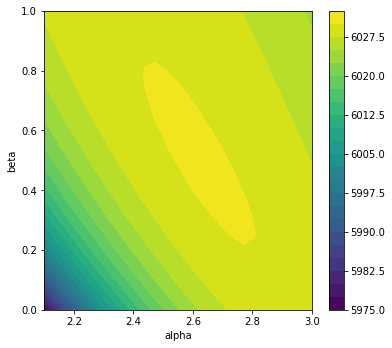

In [132]:
N = 25
betas = np.linspace(0, 1, N)
alphas = np.linspace(2.1, 3.0, N)
a, b = np.meshgrid(alphas, betas)

zs = []
for alpha, beta in tqdm(zip(a.ravel(), b.ravel())):
    p, _ = wstat_model(4, alpha, beta, observation, fit_range=fit_range)
    zs.append(p)

zs = np.array(zs)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5.5))
cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=24)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

625it [00:11, 54.05it/s]


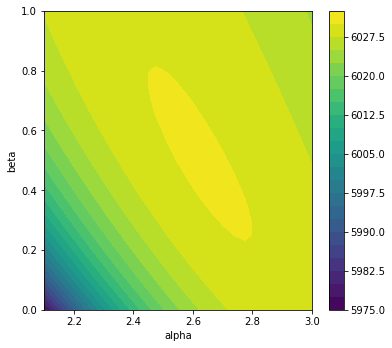

In [133]:
N = 25
betas = np.linspace(0, 1, N)
alphas = np.linspace(2.1, 3.0, N)



amplitude = T.dscalar('amplitude')
alpha = T.dscalar('alpha')
beta = T.dscalar('beta')
cf = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation)

zs = []
a, b = np.meshgrid(alphas, betas)
for al, be in tqdm(zip(a.ravel(), b.ravel())):
    mu_sig = cf.eval({amplitude: 4.0, alpha: al, beta: be})
    
    p, _ = wstat_model_from_counts(mu_sig, observation, fit_range=fit_range)
    zs.append(p)

zs = np.array(zs)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5.5))
cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=24)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

In [219]:
on_data = observation.on_vector.data.data.value
off_data = observation.off_vector.data.data.value
    
on_data, off_data, obs_alpha = apply_range(on_data, off_data, observation.alpha, fit_range=fit_range, bins=energy_bins)

exposure_ratio = observation.alpha[0]   # 1/9 = 0.11111

model = pm.Model(theano_config={'compute_test_value': 'ignore'})
with model:
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    amplitude = BoundedNormal('amplitude', mu=4, sd=2, testval=4)
    alpha = BoundedNormal('alpha', mu=2.5, sd=1, testval=2.5)
    beta = BoundedNormal('beta', mu=0.5, sd=1, testval=0.4)
    
#     amplitude = pm.HalfFlat('amplitude',testval=4)
#     alpha = pm.HalfFlat('alpha', testval=2.5)
#     beta = pm.HalfFlat('beta', testval=0.5)
    
    mu_s = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation, fit_range=fit_range)

    mu_b = BoundedNormal('mu_b', mu=off_data, sd=5.0, shape=len(off_data))
#     mu_b = pm.Normal('mu_b', mu=off_data, sd=20, shape=len(off_data))

    b = pm.Poisson('background', mu=mu_b, observed=off_data)    
    s = pm.Poisson('signal', mu=mu_s + exposure_ratio * mu_b, observed=on_data)

In [220]:
model.test_point

{'amplitude_lowerbound__': array(1.38629436),
 'alpha_lowerbound__': array(0.91629073),
 'beta_lowerbound__': array(-0.91629073),
 'mu_b_lowerbound__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [221]:
map_estimate = pm.find_MAP(model=model)
map_estimate

logp = -255.45, ||grad|| = 0.072544: 100%|██████████| 961/961 [04:46<00:00,  3.35it/s] 


{'amplitude_lowerbound__': array(1.25966545),
 'alpha_lowerbound__': array(0.94359792),
 'beta_lowerbound__': array(-0.88968109),
 'mu_b_lowerbound__': array([-10.41674381, -10.41674381, -10.41674381,   4.28528995,
          5.69212155,   5.67261098,   5.86757888,   5.5548518 ,
          5.44443051,   5.26695507,   5.03105323,   4.89350227,
          4.60798014,   4.15896022,   4.14138869,   4.12885266,
          3.64905227,   3.49115289,   3.10130745,   2.94759459,
          2.69628615,   2.31097151,   2.63092725,   1.68973934,
          1.96874721,   1.94551524,   1.64046572,   1.29328652,
         -0.10284062,   0.35290056,   0.59482659, -10.41674381,
        -10.41674381, -10.41674381]),
 'amplitude': array(3.52424227),
 'alpha': array(2.56920862),
 'beta': array(0.41078674),
 'mu_b': array([2.99271694e-05, 2.99271694e-05, 2.99271694e-05, 7.26236007e+01,
        2.96522041e+02, 2.90792799e+02, 3.53392339e+02, 2.58488653e+02,
        2.31465426e+02, 1.93824881e+02, 1.53094171e+02, 1

In [222]:
with model:
#     step = pm.Metropolis()
#     trace = pm.sample(10000, step=step, start=map_estimate)
    trace = pm.sample(1000, start={'amplitude': 3.5, 'alpha': 2.5, 'beta': 0.4}, init='auto')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

In [ ]:
pm.traceplot(trace)

/home/kbruegge/envs/gammapy/lib/python3.7/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8ef769a58>,
      dtype=object)

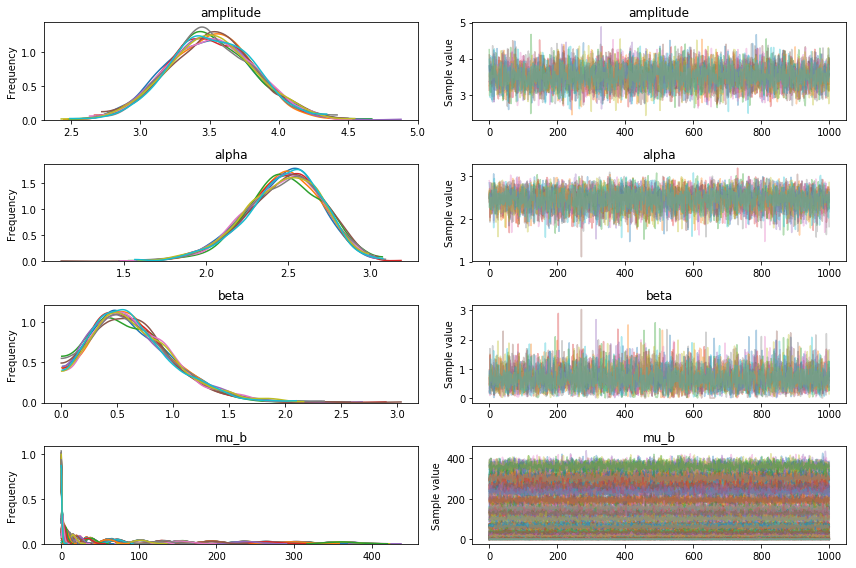

In [139]:
pm.traceplot(trace)

In [161]:
with pm.Model() as model:
    sigma = pm.HalfNormal('sigma', sd=1)
    mu = pm.Normal('mu', mu=10, sd=5)
    obs = pm.Normal('obs', mu=mu, sd=sigma, observed=np.random.randn(100) + 10)

    trace = pm.sample(1000, tune=1000)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:02<00:00, 3270.74draws/s]


In [162]:
model.test_point

{'sigma_log__': array(-0.22579135), 'mu': array(10.)}

/home/kbruegge/envs/gammapy/lib/python3.7/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8a657b6a0>,
      dtype=object)

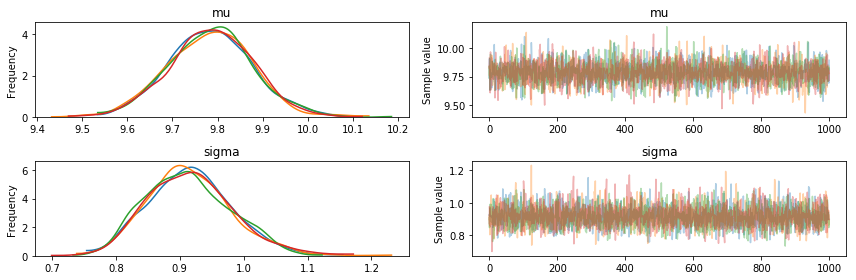

In [163]:
pm.traceplot(trace)